# NOTEBOOK FOR ANALYSIS ON CONFIDENCE ESTIMATES

This is a notebook to investigate confidence estimation for UQ related work

In [1]:
#from datetime import date
#import itertools
#import os
#import pickle
#import numpy as np

#import jsonlines
#import pandas as pd
#import sys

#import json
#import warnings
#import requests

import time
import os
import json
import pprint
pp = pprint.PrettyPrinter(indent=4)
import sampling
import numpy as np
import random

#from datasets import load_dataset
#from evaluate import load
#exact_match_metric = load("exact_match")

import evaluation
import uq_from_similarity

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
# MatPlot inline magic and plot prettification
#%matplotlib inline
#matplotlib.style.use('seaborn-whitegrid')
#font = {'size'   : 22}
#matplotlib.rc('font', **font)

# Widen the notebook...
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

#pip install sentence_transformers

### Load Data

In [2]:
# load data
dataset = 'spider_codellama'

#dataset = 'spider_granite'

#dataset = 'spider_deepseeker'

dataset = 'spider_realistic_codellama'

sampling_type = 'temp_first'
#sampling_type = 'temp_all'
split = 'dev'
#split = 'test'
temperature = None

#sampling_type = 'standard'
#temperature = '0.25'
#temperature = '1.0'

if dataset == 'spider_codellama' or dataset == 'spider_granite' or dataset == 'spider_realistic_codellama':
    samples_data = \
    evaluation.load_and_process_samples_data_spider_codellama_fewshot(dataset, sampling_type, split, temperature)
elif dataset == 'spider_deepseeker':
    samples_data = evaluation.load_and_process_samples_data_spider_deepseeker(sampling_type)    


In [3]:
# split it once
frac_test = 0.5

num_queries = len(samples_data)
num_instances_test_set = int(np.floor(frac_test * num_queries))
num_instances_valid_set = num_queries - num_instances_test_set

SEED = 10
random.seed(SEED)

indices_queries = list(range(num_queries))
random.shuffle(indices_queries)
samples_data_valid = [samples_data[i] for i in indices_queries[:num_instances_valid_set]]
samples_data_test = [samples_data[i] for i in indices_queries[num_instances_valid_set:]]

In [4]:
len(samples_data_test)

254

In [5]:
samples_data_test[0]

{'question': 'How many flights depart from APG?',
 'gt_sql': 'select count(*) from flights where sourceairport = "apg"',
 'samples': [{'gen_sql': 'select count(*) as num_flights from flights where source_airport = "apg"',
   'exec_acc': 0,
   'score': -0.1614285},
  {'gen_sql': 'select count(*) as numflights from flights where source_airport = "apg"',
   'exec_acc': 0,
   'score': -0.16566785},
  {'gen_sql': 'select count(distinct flightno) as numflights from flights where sourceairport = "apg"',
   'exec_acc': 1,
   'score': -0.27437829},
  {'gen_sql': 'select count(*) from flights where source_airport = "apg"',
   'exec_acc': 0,
   'score': -0.21395384},
  {'gen_sql': 'select count(*) from flights where source_airport = "apg"',
   'exec_acc': 0,
   'score': -0.2013805},
  {'gen_sql': 'here is a query to', 'exec_acc': 0, 'score': -8.52260644}]}

In [ ]:
# inputs 

num_bins = 10
#eps = 0.0001
#eps = 0

eps = 0.000001


#setting = 'gens|jaccard|agg-arith'
#setting = 'gens|jaccard|bayes-post:mixed'

#setting = 'gens|jaccard|bayes-post:beta'

#setting = 'gens|jaccard|clf:lr'
setting = 'gens|jaccard|clf:rf'
#setting = 'gens|jaccard|clf:qda'
#setting = 'gens|jaccard|clf:svm'


#setting = 'gens|sbert|clf:lr'


#setting = 'gens|aligon|agg-arith'

sim_type, uq_type = setting.split('|')[1], setting.split('|')[2]


In [ ]:
sim_type

In [ ]:
#sim_dict = {}

dataset = 'codellama'
sim_dict = uq_from_similarity.prep_and_save_sim_dict_ettubench(dataset, sim_type, save_bool=False)

In [ ]:
#len(sim_dict['Find the minimum grade of students who have no friends.'])
for q in sim_dict:
    print(len(sim_dict[q]))

In [ ]:

split_index = None # doesn't matter for now -- only used to hardcode bayes_mix case

bayes_param_dict = {}
clf = None
sim_dict = {}


if 'bayes' in uq_type:
    # prepare data and fit model
    bayes_type = uq_type.split('-')[1]
    sim_dist_type = bayes_type.split(':')[1]
    
    acc_list_full, beta_data_given_correct, beta_data_given_incorrect, _ = \
        uq_from_similarity.prepare_bayes_data(samples_data_valid, sim_type, eps)
    p = np.mean(acc_list_full)
    
    bayes_param_dict = \
    uq_from_similarity.prepare_bayes_param_dict(split_index, uq_type, sim_dist_type, 
                                                beta_data_given_correct, beta_data_given_incorrect, eps)
    bayes_param_dict['p'] = p
elif 'clf' in uq_type:
    
    # prepare data and fit classifier
    clf_type = uq_type.split(':')[1]
    
    acc_list_full, X = \
    uq_from_similarity.prepare_clf_data(samples_data_valid, sim_type, sim_dict, eps)
    clf = uq_from_similarity.fit_classifier(acc_list_full, X, clf_type)

    
conf_dict = uq_from_similarity.prepare_conf_dict(samples_data_test, sim_type, sim_dict, uq_type, bayes_param_dict, clf, eps)

In [ ]:
conf_dict

In [ ]:
clf.coef_

In [ ]:
clf.intercept_

In [ ]:
clf.score(X, acc_list_full)

In [ ]:
# test
acc_list_full_test, X_test = \
uq_from_similarity.prepare_log_reg_data(samples_data_test, sim_type, eps)
clf.score(X_test, acc_list_full_test)




with sorting

dev: 0.7994842037395229
test: 0.718568665377176

w/o sorting

dev: 0.7959381044487428
test: 0.7237266279819471

w/o skipping:

dev: 0.7875564152159897
test: 0.7230818826563508


only using mean of sims:

dev: 0.7882011605415861
test: 0.7205029013539652

as above but no intercept:

dev: 0.7956157317859446
test: 0.7198581560283688

mean of sims but no logit:

dev: 0.7840103159252095
test: 0.721792392005158

all off diag sims:
dev: 0.7756286266924565
test: 0.7005157962604771


regular (skipping i) plus mean sim over all:

dev: 0.8001289490651193
test: 0.7243713733075435



In [ ]:
conf_dict

In [ ]:
num_bins = 5

num_queries = len(samples_data_test)
num_samples = len(samples_data_test[0]['samples'])

indices_of_interest = [0]

for sample_index in indices_of_interest:
    print('sample index:', sample_index)
    accuracy_list = \
    [samples_data_test[query_index]['samples'][sample_index]['exec_acc'] for query_index in range(num_queries)]
    conf_list = [conf_dict[query_index][sample_index] for query_index in range(num_queries)]
    auroc, auarc, ece, ace, rmsce = evaluation.evaluate_metrics(accuracy_list, conf_list, num_bins)
    
    print('auroc:', auroc)
    print('auarc:', auarc)
    print('ece:', ece)
    print('ace:', ace)
    print('rmsce:', rmsce)
    print('\n')


In [ ]:
# separate out confidences samples

conf_correct = [conf_list[i] for i in range(len(conf_list)) if accuracy_list[i] == 1]
conf_incorrect = [conf_list[i] for i in range(len(conf_list)) if accuracy_list[i] != 1]

print(len(conf_correct))
print(len(conf_incorrect))


In [ ]:
# plot histograms
def plot_histograms(x, y, title, xlabel):
    
    bins = np.linspace(0, 1, 30)
    plt.hist(x, bins, alpha=0.5, label='Correct', color = 'blue', edgecolor = 'black')
    plt.hist(y, bins, alpha=0.5, label='Incorrect', color = 'green', edgecolor = 'black')
    
    #plt.ylim(0, 50)
    
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xlabel(xlabel)
    plt.show()
    

In [ ]:
x = conf_correct
y = conf_incorrect

#plt.style.use('seaborn-deep')

title = 'spi-dev,sample ' + str(indices_of_interest[0]+1) + ',' + sampling_type + ': ' + setting
xlabel = 'auroc: ' + str(round(auroc,2)) + '; auarc: ' + str(round(auarc,2))

plot_histograms(x, y, title, xlabel)

### Check by distinguishing whether at least 1 correct or not

In [ ]:
# check if query has at least 1 correct answer
def query_at_least_one_correct(samples_data_test, query_index):
    
    samples = samples_data_test[query_index]['samples']
    acc = [samples[sample_index]['exec_acc'] for sample_index in range(len(samples))]
    
    return True if 1 in acc else False


# check how many correct responses
def query_num_correct(samples_data_test, query_index):
    
    samples = samples_data_test[query_index]['samples']
    acc = [samples[sample_index]['exec_acc'] for sample_index in range(len(samples))]
    
    return sum(acc)


# return accuracies and confidences of queries with specified indices
def acc_and_conf_specified_indices(samples_data_test, conf_dict, query_indices):
    
    acc_list = \
    [samples_data_test[query_index]['samples'][sample_index]['exec_acc'] for query_index in query_indices]
    conf_list = [conf_dict[query_index][sample_index] for query_index in query_indices]
    
    return acc_list, conf_list

In [ ]:
# get indices
indices_C, indices_I = [], []

num_queries = len(samples_data_test)
for query_index in range(num_queries):
    
    if query_at_least_one_correct(samples_data_test, query_index):
        indices_C.append(query_index)
    else:
        indices_I.append(query_index)

print(len(indices_C))
print(len(indices_I))

In [ ]:
# 3 different subsets of queries: 


num_bins = 10

num_queries = len(samples_data_test)
num_samples = len(samples_data_test[0]['samples'])

indices_of_interest = [0]

for sample_index in indices_of_interest:
    print('sample index:', sample_index)
    
    acc_list_C, conf_list_C = acc_and_conf_specified_indices(samples_data_test, conf_dict, indices_C)
    acc_list_I, conf_list_I = acc_and_conf_specified_indices(samples_data_test, conf_dict, indices_I)
    
    auroc_C, auarc_C, ece_C, ace_C = evaluation.evaluate_metrics(acc_list_C, conf_list_C, num_bins)
    print('auroc_C:', auroc_C)
    print('auarc_C:', auarc_C)
    print('ece_C:', ece_C)
    print('ace_C:', ace_C)
    print('\n')
    auroc_I, auarc_I, ece_I, ace_I = evaluation.evaluate_metrics(acc_list_I, conf_list_I, num_bins)
    print('auroc_I:', auroc_I)
    print('auarc_I:', auarc_I)
    print('ece_I', ece_I)
    print('ace_I:', ace_I)
    print('\n')



In [ ]:
# separate out confidences samples

conf_correct_given_C = [conf_list_C[i] for i in range(len(conf_list_C)) if acc_list_C[i] == 1]
conf_incorrect_given_C = [conf_list_C[i] for i in range(len(conf_list_C)) if acc_list_C[i] != 1]

print(len(conf_correct_given_C))
print(len(conf_incorrect_given_C))
print(len(conf_list_I))


In [ ]:
212+64+241

In [ ]:
# subset based on correct

indices_C_only, indices_C_more, indices_C_none = [], [], []

num_queries = len(samples_data_test)
for query_index in range(num_queries):
    
    if query_num_correct(samples_data_test, query_index)>1:
        indices_C_more.append(query_index)
    elif query_num_correct(samples_data_test, query_index)==1:
        indices_C_only.append(query_index)
    else:
        indices_C_none.append(query_index)

print(len(indices_C_more))
print(len(indices_C_only))
print(len(indices_C_none))

In [ ]:

indices_of_interest = [0]

for sample_index in indices_of_interest:
    print('sample index:', sample_index)
    
    acc_list_C_more, conf_list_C_more = acc_and_conf_specified_indices(samples_data_test, conf_dict, indices_C_more)
    acc_list_C_only, conf_list_C_only = acc_and_conf_specified_indices(samples_data_test, conf_dict, indices_C_only)

# separate out confidences samples

conf_C_more = [conf_list_C_more[i] for i in range(len(conf_list_C_more)) if acc_list_C_more[i] == 1]
conf_C_only = [conf_list_C_only[i] for i in range(len(conf_list_C_only)) if acc_list_C_only[i] == 1]

#conf_incorrect_given_C = [conf_list_C[i] for i in range(len(conf_list_C)) if acc_list_C[i] != 1]

print(len(conf_C_more))
print(len(conf_C_only))
print(len(conf_list_I))

In [ ]:
# plot histograms
def plot_3_histograms(x, y, z, title, xlabel, xleg, yleg, zleg):
    
    bins = np.linspace(0, 1, 30)
    plt.hist(x, bins, alpha=0.5, label=xleg, color = 'blue', edgecolor = 'black')
    plt.hist(y, bins, alpha=0.5, label=yleg, color = 'green', edgecolor = 'black')
    plt.hist(z, bins, alpha=0.5, label=zleg, color = 'red', edgecolor = 'black')
    
    
    #plt.hist([x, y, z], bins, label=['x', 'y', 'z'], color = ['blue', 'green', 'red'])
    
    plt.ylim(0, 100)

    
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xlabel(xlabel)
    plt.show()

In [ ]:


x = conf_correct_given_C
y = conf_incorrect_given_C
z = conf_list_I

#plt.style.use('seaborn-deep')

title = 'spi-dev,sample ' + str(indices_of_interest[0]+1) + ',' + sampling_type + ': ' + setting
xlabel = 'auroc: ' + str(round(auroc,2)) + '; auarc: ' + str(round(auarc,2))

xleg = 'Correct (given >=1 correct)'
yleg = 'Incorrect (given >=1 correct)'
zleg = 'Incorrect (none correct)'

plot_3_histograms(x, y, z, title, xlabel, xleg, yleg, zleg)

In [ ]:

x = conf_C_more
y = conf_C_only
z = conf_list_I

title = ''
xlabel = ''

xleg = ''
yleg = ''
zleg = ''

plot_3_histograms(x, y, z, title, xlabel, xleg, yleg, zleg)

In [ ]:
y

In [ ]:
x

In [ ]:
a = [1, 2, 5, 2]
np.sort(a)

In [ ]:

setting = 'gens|jaccard|agg-arith'

auroc_C: 0.6122494103773585
auarc_C: 0.8326357557964694
ece_C: 0.24953483669186094
ace_C: 0.3697668712225828

    
setting = 'gens|jaccard|lr'
    
auroc_C: 0.6477004716981132
auarc_C: 0.8569164676903078
ece_C: 0.350790054880888
ace_C: 0.43944556313746763


In [ ]:
# mixed approach
p_0_C, p_1_C, alpha_C, beta_C, p_0_I, p_1_I, alpha_I, beta_I = \
uq_from_similarity.fit_sim_dist_mixed(beta_data_given_correct, beta_data_given_incorrect, eps)

In [ ]:
p_0_C, p_1_C, alpha_C, beta_C, p_0_I, p_1_I, alpha_I, beta_I

In [ ]:
all_beta_data

In [ ]:
plt.hist(all_beta_data,bins=30, density=True)
plt.show()

print('Mean:', np.mean(all_beta_data))

In [ ]:
plt.hist(beta_data_given_correct,bins=30, density=True)
plt.show()

print('Mean:', np.mean(beta_data_given_correct))

num_zeros = sum(np.array(beta_data_given_correct)==0.0001)
num_ones = sum(np.array(beta_data_given_correct)==0.9999)
tot = len(beta_data_given_correct)

print('Fraction of zeros:', num_zeros/tot)
print('Fraction of ones:', num_ones/tot)


In [ ]:
plt.hist(beta_data_given_incorrect,bins=30, density=True)
plt.show()

print('Mean:', np.mean(beta_data_given_incorrect))

num_zeros = sum(np.array(beta_data_given_incorrect)==0.0001)
num_ones = sum(np.array(beta_data_given_incorrect)==0.9999)

tot = len(beta_data_given_incorrect)

print('Fraction of zeros:', num_zeros/tot)
print('Fraction of ones:', num_ones/tot)

In [ ]:
# plotting for mixed approach
def plot_data_mixed(data, p_0, p_1, alpha, beta, eps, plot_title, bins=30):
    
    plt.hist(data,bins=30, density=True)
    #fitted_beta=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta
    #fitted_mixed=lambda x:uq_from_similarity.compute_pdf_mixed(x,p_0,p_1,alpha,beta,eps) #pdf of mixed

    xx = np.linspace(eps,1-eps,len(data))
    yy = [uq_from_similarity.compute_pdf_mixed(x,p_0,p_1,alpha,beta,eps) for x in xx]
    
    #plt.plot(xx,fitted(xx,a,b),'r')
    plt.plot(xx,yy,'r')
    plt.xlabel('Similarity')
    plt.title(plot_title)
    
    print('Mean:', np.mean(data))



In [ ]:
# plot for correct -- mixed

plot_title = 'Distribution of Similarity Given Correct Response'
plot_data_mixed(beta_data_given_correct, p_0_C, p_1_C, alpha_C, beta_C, eps, plot_title)


In [ ]:
# plot for incorrect -- mixed

plot_title = 'Distribution of Similarity Given Incorrect Response'
plot_data_mixed(beta_data_given_incorrect, p_0_I, p_1_I, alpha_I, beta_I, eps, plot_title)

In [ ]:
def plot_data(data, weights, alphas, betas, plot_title, bins=30):
    
    plt.hist(data,bins=30, density=True)
    #fitted_beta=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta
    fitted_beta_mix=lambda x,weights,alphas,betas:uq_from_similarity.compute_pdf_mixture_betas(x, weights, alphas, betas) #pdf of beta

    xx=np.linspace(0,max(data),len(data))
    #plt.plot(xx,fitted(xx,a,b),'r')
    plt.plot(xx,fitted_beta_mix(xx,weights,alphas,betas),'r')
    plt.xlabel('Similarity')
    plt.title(plot_title)
    
    print('Mean:', np.mean(data))


In [ ]:
from scipy.special import gamma as gammaf

    
plot_title = 'Distribution of Similarity Given Correct Response'
plot_data(beta_data_given_correct, weights_C, alphas_C, betas_C, plot_title)


In [ ]:

plot_title = 'Distribution of Similarity Given Incorrect Response'
plot_data(beta_data_given_incorrect, weights_I, alphas_I, betas_I, plot_title)


### Similarity Distribution

In [6]:
#sim_type = 'jaccard'
#sim_type = 'output_type'

#sim_type = 'rouge1'
sim_type = 'sbert'


#all_pairwise_sims, all_pairwise_sims_dict = uq_from_similarity.get_all_pairwise_sims(samples_data_valid, sim_type)

all_pairwise_sims, all_pairwise_sims_dict = uq_from_similarity.get_all_pairwise_sims(samples_data, sim_type)

Obtained similarity pairs up to query: 50
Obtained similarity pairs up to query: 100
Obtained similarity pairs up to query: 150
Obtained similarity pairs up to query: 200
Obtained similarity pairs up to query: 250
Obtained similarity pairs up to query: 300
Obtained similarity pairs up to query: 350
Obtained similarity pairs up to query: 400
Obtained similarity pairs up to query: 450
Obtained similarity pairs up to query: 500


In [7]:
# plot sim histograms
def plot_sim_histogram(x, sim_type):
    
    bins = np.linspace(0, 1, 30)
    plt.hist(x, bins, alpha=0.5, color = 'blue', edgecolor = 'black')
    
    #plt.ylim(0, 50)
    
    plt.title(sim_type)
    #plt.legend(loc='upper right')
    #plt.xlabel(xlabel)
    plt.show()


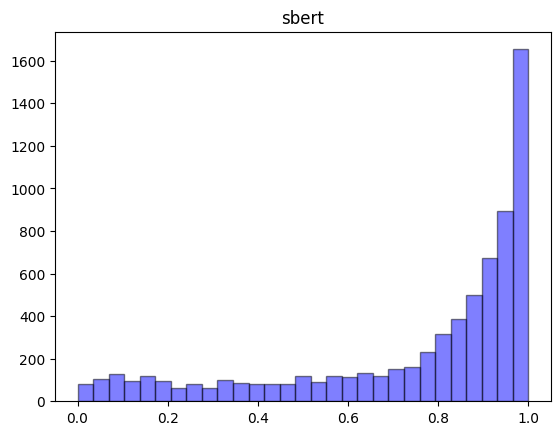

In [8]:
plot_sim_histogram(all_pairwise_sims, sim_type)

In [9]:
# save output
save_bool = True

output_filename = 'sim_dict_' + dataset + '_' + split + '_' + sampling_type + '_' + sim_type + '.json'

if save_bool:
    with open(output_filename, "w") as outfile:
        json.dump(all_pairwise_sims_dict, outfile)

In [ ]:
q = 'Which employee received the biggest bonus? Give me the employee name.'

all_pairwise_sims_dict[q]

### Prepare Files for Confidence Estimates

In [ ]:
# load data
dataset = 'spider_deepseeker'

sampling_type = 'temp_all'
split = 'dev'

temperature = None

samples_data = evaluation.load_and_process_samples_data_spider_deepseeker(sampling_type)


In [ ]:
samples_data[0]

In [ ]:
# inputs

frac_test = 0.5 
num_test_samples = 5


In [ ]:
output_dict = evaluation.run_conf_estimates_exp(samples_data, frac_test, num_test_samples)

In [ ]:
len(output_dict)

In [ ]:
len(output_dict[1])

In [ ]:
save_bool = True

# save file
output_filename = 'gens_with_conf_estimates_' + dataset + '.json'

if save_bool:
    with open(output_filename, "w") as outfile:
        json.dump(output_dict, outfile)

### Plotting for Temperature Sampling


Dataset: spider realistic dev
Model: few-shot codellama

Metric: jaccard
Aggregation: agg-arith


temp -- of eval interest: 0.25


jaccard

standard sampling: 

1st sample:

AUROC:  0.6715274239275942 +/- 0.030955133150776137
AUARC:  0.7381052317383355 +/- 0.022475156758779258
ACE:  0.11499890749366781 +/- 0.020210089072388707

2nd sample:

standard sampling: 

AUROC:  0.6988542725294471 +/- 0.030685782804071415
AUARC:  0.7262212377889504 +/- 0.02491604506128242
ACE:  0.14979396621077828 +/- 0.023505781303082368

3rd sample:

AUROC:  0.6802945716123265 +/- 0.016747977116716217
AUARC:  0.7036767743029976 +/- 0.019730853225696288
ACE:  0.155472584918251 +/- 0.023152421887036465

4th sample:

AUROC:  0.6850454703658431 +/- 0.030093294824111216
AUARC:  0.7121245852665202 +/- 0.01804517741229672
ACE:  0.15930309301647042 +/- 0.014126292216105299

5th sample:

AUROC:  0.6902926368769771 +/- 0.031434190809190854
AUARC:  0.7374556951539741 +/- 0.026726245024067397
ACE:  0.13145709089879945 +/- 0.021317872514140995


temp first:

1st sample:

AUROC:  0.6722678096642681 +/- 0.03197867541768018
AUARC:  0.7470540193143892 +/- 0.018753071437359825
ACE:  0.05981865235225403 +/- 0.020342527936712693


temp all:

1st sample:

AUROC:  0.6960616248971305 +/- 0.026515853309571957
AUARC:  0.754043193948329 +/- 0.013206575714485858
ACE:  0.0956279809070239 +/- 0.023043937395023292




rougeL

standard sampling:

1st sample:

AUROC:  0.665485064369838 +/- 0.03211427416884871
AUARC:  0.7400940683811765 +/- 0.031812240804933445
ECE:  0.26027309874785765 +/- 0.029390112022898887
ACE:  0.2950174388512969 +/- 0.0437466420147061

2nd sample

AUROC:  0.6898181374476972 +/- 0.039632485569985554
AUARC:  0.726693663902688 +/- 0.027998098952632944
ECE:  0.29645712049287054 +/- 0.022527543997335753
ACE:  0.3378579348574041 +/- 0.03394498745903274

3rd sample:

AUROC:  0.6862600734204213 +/- 0.025739183002955357
AUARC:  0.71084067521362 +/- 0.028547571709891084
ACE:  0.3477886752712793 +/- 0.037617064654273946

4th sample:

AUROC:  0.6861745739196113 +/- 0.03569238495468824
AUARC:  0.720242761215828 +/- 0.013753719050465518
ECE:  0.3099274229047243 +/- 0.01645258545713385
ACE:  0.3526083741458691 +/- 0.024343504706742625

5th sample:

AUROC:  0.687892872330129 +/- 0.034961080586080606
AUARC:  0.7274905722094094 +/- 0.02249048222309047
ACE:  0.3168516416854746 +/- 0.024100071082566427


temp first:

1st sample:

AUROC:  0.6592060179121952 +/- 0.03412032055691766
AUARC:  0.7240328460385832 +/- 0.024843876260371378
ACE:  0.09941845805433451 +/- 0.02981854462304978


temp all:

1st sample:

AUROC:  0.70758169397265 +/- 0.028355717829405935
AUARC:  0.7529548956158996 +/- 0.009157411164903262
ECE:  0.052389900006842585 +/- 0.02537955631066807
ACE:  0.08421359513895857 +/- 0.027732655562890535


In [ ]:
ace_vec_standard_jaccard = []




In [ ]:
def plot_grouped_charts(X, standard, temp, hybrid, y_lim_upper, metric):
    
    N = len(X)
    ind = np.arange(N)  
    width = 0.25   
    
    X_axis = np.arange(len(X)) 
  
    plt.bar(ind, standard, width, label = 'Standard') 
    plt.bar(ind+width, temp, width, label = 'Temperature') 
    plt.bar(ind+width*2, hybrid, width, label = 'Hybrid') 
    plt.ylim(0, y_lim_upper)
  
    plt.xticks(ind+width, X, fontsize=18) 
    #plt.xlabel("Similarity Metrics") 
    plt.ylabel(metric, fontsize=20) 
    #plt.title("Comparing Sampling Techniques: " + metric, fontsize=16) 
    plt.title("Sampling Type Comparison", fontsize=18) 
    plt.legend(fontsize=12) 
    plt.show() 
      

In [ ]:
# 3 METRICS

# plot ACE

X = ['Jaccard', 'RougeL', 'Output type'] 

standard = [0.373, 0.537, 0.439] 
temp = [0.162, 0.311, 0.409] 
hybrid = [0.126, 0.300, 0.413]

y_lim_upper = 0.6
metric = 'ACE'

plot_grouped_charts(X, standard, temp, hybrid, y_lim_upper, metric)

In [ ]:
# 3 METRICS

# plot AUROC

X = ['Jaccard', 'RougeL', 'Output type'] 

standard = [0.64, 0.60, 0.53] 
temp = [0.64, 0.62, 0.62] 
hybrid = [0.66, 0.65, 0.65]

y_lim_upper = 1
metric = 'AUROC'

plot_grouped_charts(X, standard, temp, hybrid, y_lim_upper, metric)

In [ ]:
# 3 METRICS

# plot AUARC

X = ['Jaccard', 'RougeL', 'Output type'] 

standard = [0.49, 0.47, 0.42] 
temp = [0.51, 0.48, 0.48] 
hybrid = [0.53, 0.51, 0.51]

y_lim_upper = 1
metric = 'AUARC'

plot_grouped_charts(X, standard, temp, hybrid, y_lim_upper, metric)